In [1]:
import tensorflow as tf

In [ ]:
from numpy_ringbuffer import RingBuffer

REAPLAY_MEMORY_SIZE = int(4e3) # should be 1e6
REPLAY_START_SIZE = int(3.5e3) # should be 5e4

In [ ]:
INIT_EPS = 1
END_EPS = 0.1
FINAL_EXPLORATION_FRAME = REAPLAY_MEMORY_SIZE

DISCOUNT_FACTOR = 0.99

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from random import sample
from tensorflow.keras import layers, Model
from time import time
from timeit import timeit
from matplotlib import pyplot as plt
from tqdm import tqdm

import utils

print(tf.config.list_physical_devices('GPU')[0])

env = gym.make("ALE/Breakout-v5")

N_ACTIONS = env.action_space.n
OBS_RANGE = int(env.observation_space.high_repr) - int(env.observation_space.low_repr)
OBS_SHAPE = env.observation_space.shape
# SKIP_FRAMES = [2, 3, 4] # possible addition --> skip randomly 2/3/4 frames instead of always 4
N_INPUT_FRAMES = 4

BATCH_SIZE = 8

input_shape = [*OBS_SHAPE]
input_shape[-1] *= N_INPUT_FRAMES

experience_buffer = [
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE, dtype= (float, input_shape)),     # observation at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE),                                   # action at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE),                                   # reward at time t
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE, dtype= (float, input_shape)),     # observation at time t+1
    RingBuffer(capacity=REAPLAY_MEMORY_SIZE)                                    # is done (for target computation)
    ]

obs = np.zeros(input_shape, dtype=np.int8)

LOG_DIR = ".logs/"

model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=input_shape,
    classes=N_ACTIONS,
    classifier_activation='softmax'
)

target_model = tf.keras.models.clone_model(model)
tb_callback = tf.keras.callbacks.TensorBoard(LOG_DIR)
tb_callback.set_model(model)

# target_model_weights = model.save_weights("./target_model_weights")
TARGET_MODEL_UPDATE_FREQUENCY = 500
tr_weights = model.trainable_weights

total_params = sum([np.prod(w.get_shape().as_list()) for w in tr_weights])
print(total_params)

opt = tf.keras.optimizers.Adam(learning_rate= 1e-5)


/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/home/marcello/github/AtariGym/env/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_imag

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-04-08 00:48:33.512234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 00:48:33.513583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 00:48:33.513767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 00:48:33.513874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

4015264


In [ ]:
@tf.function
def preprocess_observation(obs):
    return tf.math.divide(tf.cast(obs, tf.float32) / tf.cast(OBS_RANGE, tf.float32))

In [ ]:
def simulate(env, action): # big but finite MDP
    i = 0
    k_reward = 0
    done = 0

    while i < N_INPUT_FRAMES and not done:

        observation, reward, done, info = env.step(action)
        obs[:, :, i:i+3] = observation # simply concatenate observations --> each is 3 channels deep
        i += 1
        k_reward += reward

    p_obs = preprocess_observation(obs)
    return p_obs, k_reward, done

In [ ]:
def add_to_buffer(buffer, tuple):
    for i, elem in enumerate(tuple):
        buffer[i].append(elem)

RETURN_LIST = [ # initialization for faster processing
    tf.Variable(tf.zeros(shape=(BATCH_SIZE, *input_shape))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE, *input_shape))),
    tf.Variable(tf.zeros(shape=(BATCH_SIZE,)))
]

def sample_from_buffer(buffer, sample_size):
    idx = sample(range(len(buffer[0])), sample_size)
    for i in range(len(buffer)):
        if i == 0 or i == 4:
          RETURN_LIST[i]= tf.vectorized_map(preprocess_observation, tf.stack(buffer[i][idx]))
    return RETURN_LIST

 10%|█         | 10000/100000 [35:12<8:16:37,  3.02it/s]

Total frame 10000 Total time passed:  2113.6321592330933


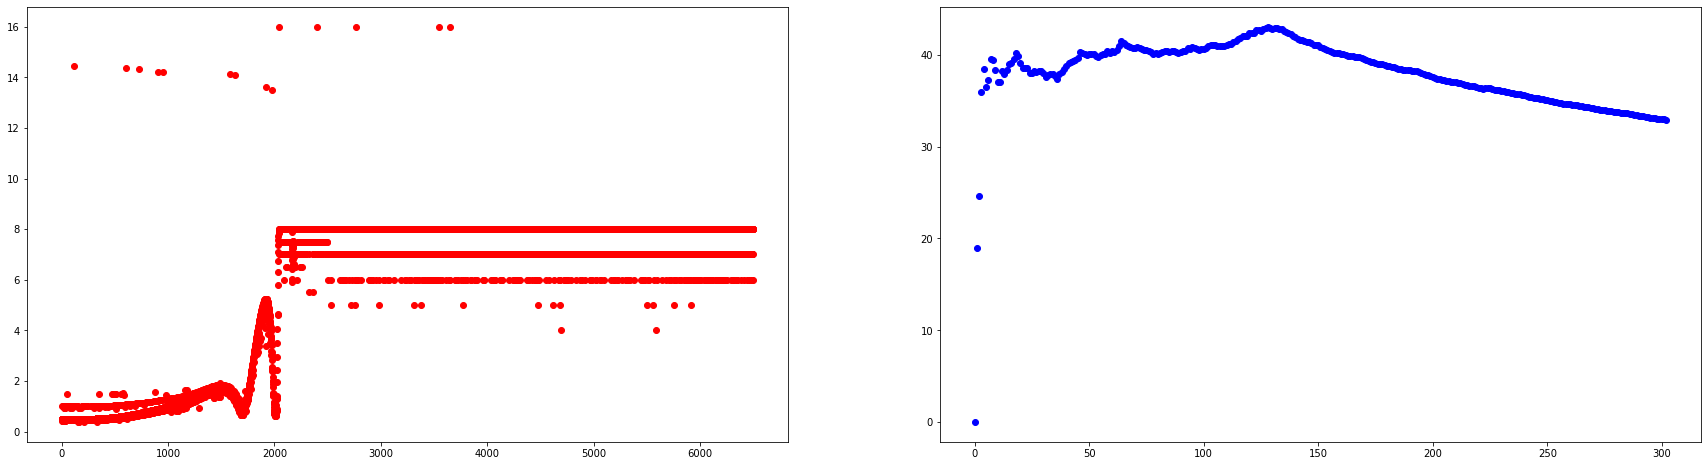

 20%|██        | 20000/100000 [1:31:14<7:57:44,  2.79it/s] 

Total frame 20000 Total time passed:  5474.961016893387


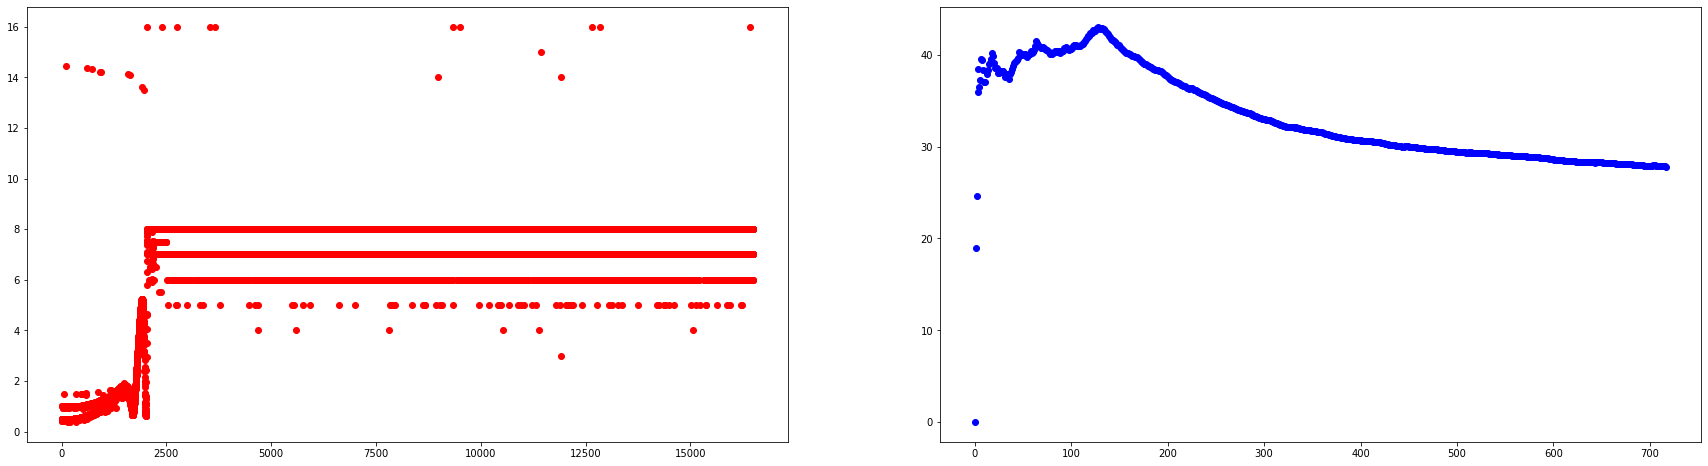

 30%|███       | 30000/100000 [2:28:13<6:23:12,  3.04it/s] 

Total frame 30000 Total time passed:  8894.344624757767


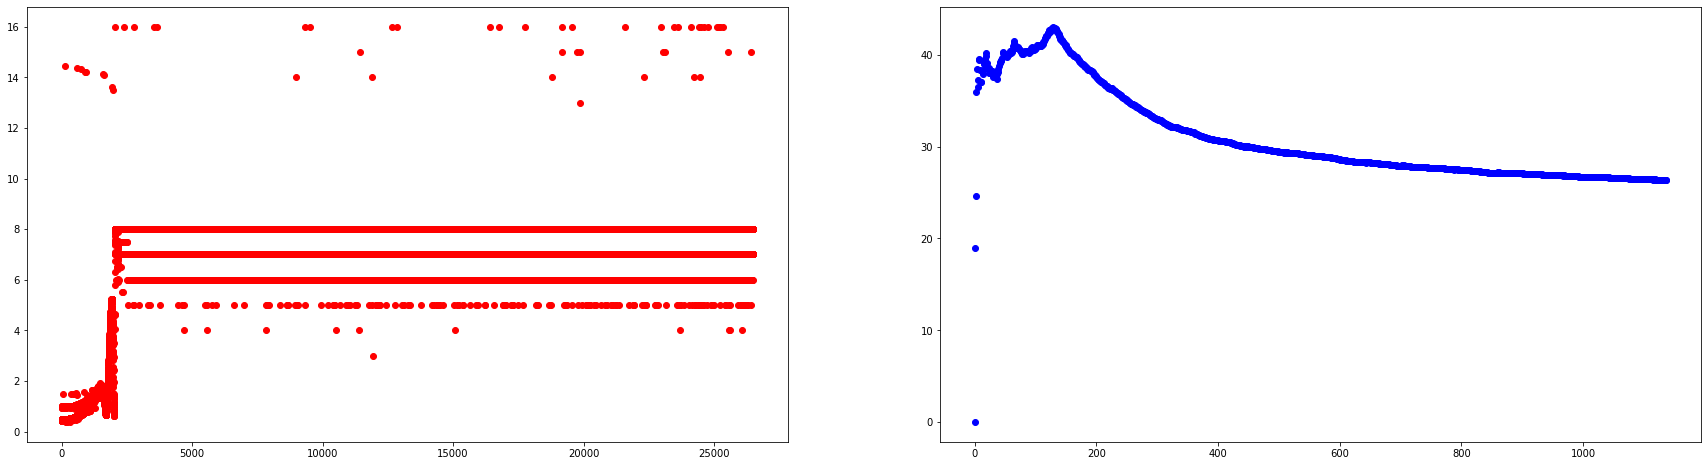

 40%|████      | 40000/100000 [3:24:00<5:57:52,  2.79it/s] 

Total frame 40000 Total time passed:  12241.922873735428


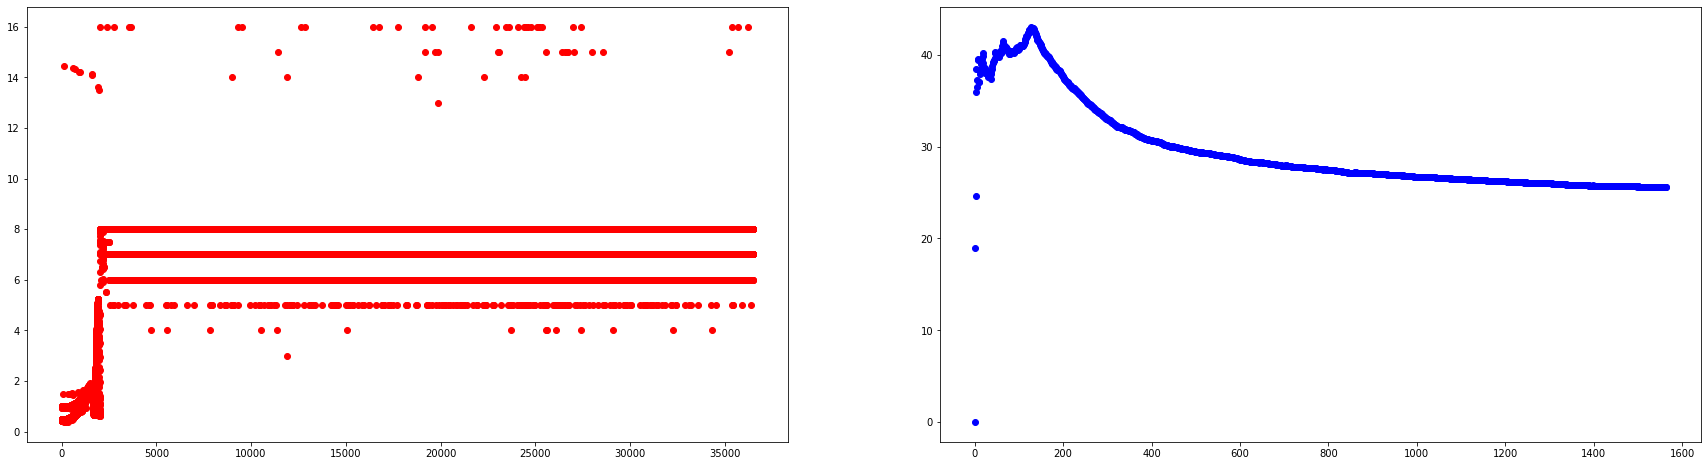

 50%|█████     | 50000/100000 [4:20:52<4:22:06,  3.18it/s] 

Total frame 50000 Total time passed:  15653.63168644905


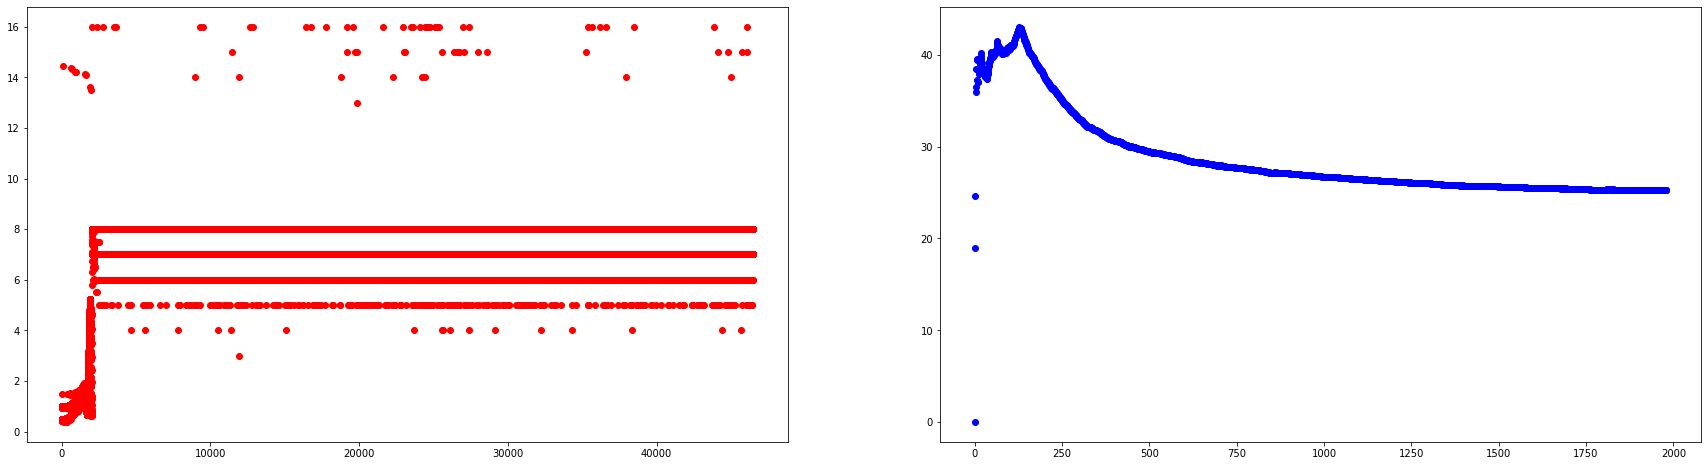

 60%|██████    | 60000/100000 [5:17:57<3:42:09,  3.00it/s]

Total frame 60000 Total time passed:  19078.01632118225


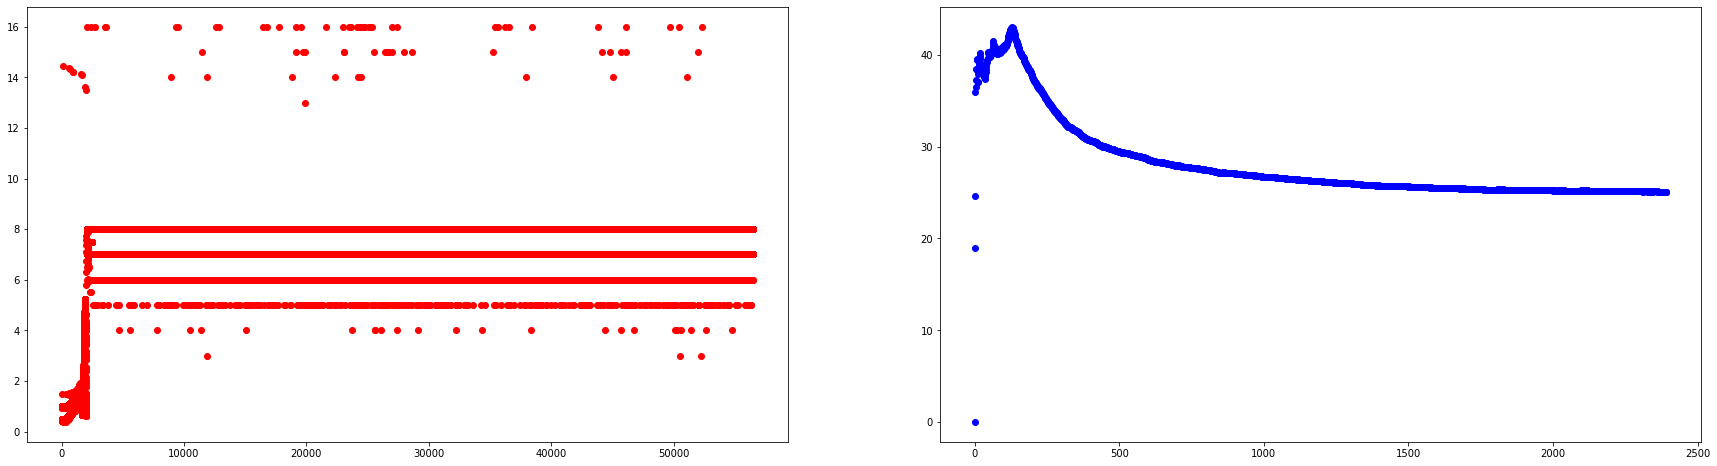

 70%|███████   | 70000/100000 [6:13:57<2:38:43,  3.15it/s]

Total frame 70000 Total time passed:  22438.594175577164


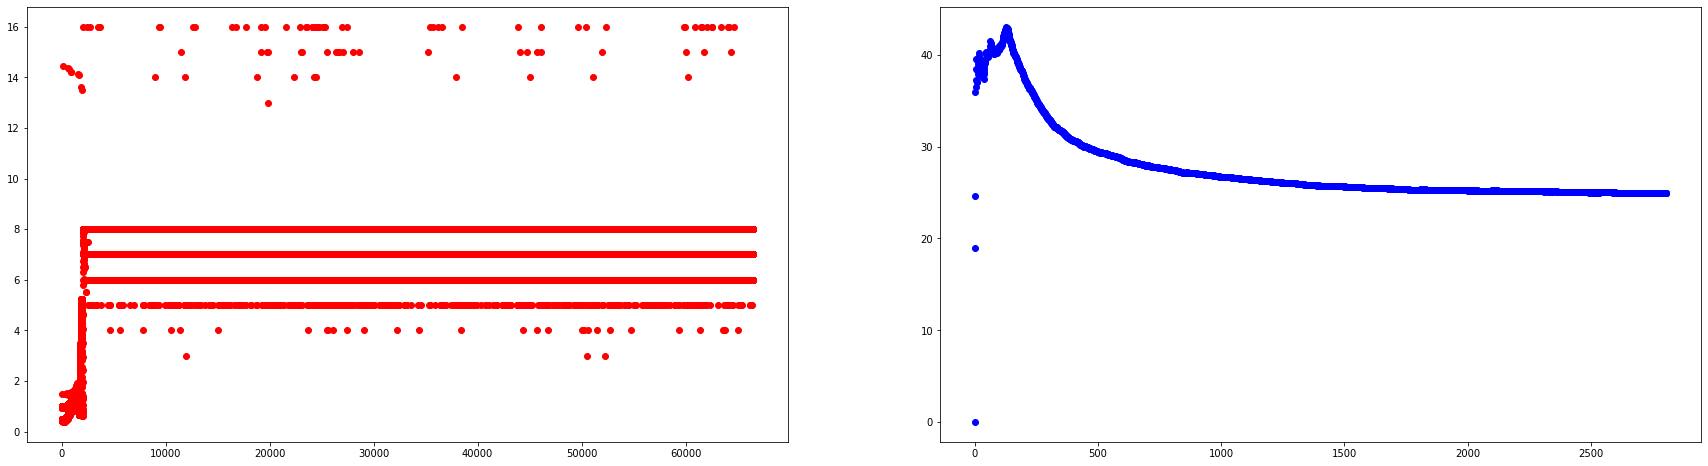

 70%|███████   | 70304/100000 [6:15:42<2:59:03,  2.76it/s]

KeyboardInterrupt: 

In [ ]:
MAX_TOTAL_FRAMES = int(1e5)
MAX_FRAMES_PER_EPISODE = int(1e3)
total_frames = 0
target_model_update_frames = 0
pbar = tqdm(total = MAX_TOTAL_FRAMES)

n_episodes = 0
losses = []
episode_frames = []

observation, info = env.reset(seed=42, return_info=True)

t = time()
while total_frames < MAX_TOTAL_FRAMES:  # episodes
      
      action = env.action_space.sample() # how do you solve the first frame? which action do you choose? (since the obs are 4 frames concat)
      
      n_episodes += 1
      episode_frame_counter = 0
      episode_frames.append(total_frames/n_episodes)

      while episode_frame_counter < MAX_FRAMES_PER_EPISODE: # max n° of frames per episode

            episode_frame_counter += 1
            total_frames += 1
            pbar.update(1)
                  
            obs, reward, done = simulate(env, action) # to create the starting point for the episode (first observation is 4 frames)
            
            if total_frames < REPLAY_START_SIZE:
                  # random sampling the first "REPLAY_START_SIZE" steps
                  action = env.action_space.sample()
                  next_obs, reward, is_end_state = simulate(env, action)
                  add_to_buffer(experience_buffer, (obs, action, reward, next_obs, is_end_state))

            else:
                  eps = utils.calculate_eps(total_frames, REPLAY_START_SIZE, FINAL_EXPLORATION_FRAME, INIT_EPS, END_EPS)
                  # policy
                  action = utils.eps_greedy_policy(eps, env, model, obs)

                  # next observation
                  next_obs, reward, is_end_state = simulate(env, action)

                  # append observation, action, reward, next_observation and "done" into the experience buffer
                  add_to_buffer(experience_buffer, (obs, action, reward, net_obs, is_end_state)) # RingBuffer automatically pops from opposite side if maxlen is surpassed

                  # sample BATCH_SIZE elements from the buffer
                  batched_old_observation, batched_action, batched_reward, batched_new_observation, batched_done = sample_from_buffer(experience_buffer, BATCH_SIZE) # for the training instead batch is 32

                  # compute the max q_values for all new_observations
                  batch_q_values = tf.math.reduce_max(target_model(batched_new_observation), axis=1)

                  # select only the ones in which the model is not in its final state, because the value of the final state's target is simply the final reward
                  masked_batch_q_values = tf.multiply(tf.multiply(batch_q_values, tf.cast(batched_done, tf.float32)), DISCOUNT_FACTOR)

                  # compute the target for each transition: reward + possibly the max q_value
                  target = tf.math.add(masked_batch_q_values, tf.cast(batched_reward, tf.float32))
                  
                  # now let's train the network: we need to update the weights
                  with tf.GradientTape() as tape:
                        loss = tf.math.reduce_sum(
                              tf.math.square( 
                                    tf.subtract(
                                          target, 
                                          tf.math.reduce_max( model(batched_old_observation), axis=1 )
                                    )  
                              )
                        )

                  losses.append(loss.numpy())

                  grads = tape.gradient(loss, tr_weights)
                  # clip the gradients in [-1;+1]
                  processed_grads = map(utils.process_gradient, grads)

                  opt.apply_gradients(zip(processed_grads, tr_weights))

                  if target_model_update_frames == TARGET_MODEL_UPDATE_FREQUENCY:
                        target_model_update_frames = 0
                        model.save_weights("./weights/update_weights")
                        target_model.load_weights("./weights/update_weights")
                  target_model_update_frames += 1

                  if total_frames%10000 == 0:
                        print("Total frame", total_frames, "Total time passed: ", time()-t)
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,8))
                        ax1.scatter(range(len(losses)), losses, c="r")
                        ax2.scatter(range(len(episode_frames)), episode_frames, c="b")
                        plt.show()

            if is_end_state:
                 observation, info = env.reset(return_info=True)
                 break

      if episode_frame_counter >= MAX_FRAMES_PER_EPISODE:
            observation, info = env.reset(return_info=True)
env.close()